# Bilinear VAE on MNIST: Weight-Based Latent Space Analysis

We build a VAE with a **bilinear encoder** (no element-wise nonlinearity) and apply eigendecomposition to analyze which input patterns correspond to specific latent space coordinates — directly from the weights, without any forward passes.

In [ ]:
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as pltD
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from einops import einsum

sys.path.append('bilinear-decomposition-main')
from shared.components import Bilinear

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## Model Definition

In [2]:
class BilinearVAE(nn.Module):
    """VAE with a bilinear encoder for weight-based interpretability.
    
    Encoder: x(784) -> E(256) -> Bilinear(512) -> P_mu(10), P_logvar(10)
    Decoder: z(10) -> Linear(256) -> ReLU -> Linear(784) -> Sigmoid
    """
    def __init__(self, d_input=784, d_embed=256, d_hidden=512, d_latent=10):
        super().__init__()
        self.d_input = d_input
        self.d_embed = d_embed
        self.d_hidden = d_hidden
        self.d_latent = d_latent
        
        # Encoder
        self.embed = nn.Linear(d_input, d_embed, bias=False)
        self.bilinear = Bilinear(d_embed, d_hidden, gate=None)  # pure bilinear
        self.fc_mu = nn.Linear(d_hidden, d_latent, bias=False)
        self.fc_logvar = nn.Linear(d_hidden, d_latent)
        
        # Decoder (standard, not bilinear)
        self.dec_fc1 = nn.Linear(d_latent, d_embed)
        self.dec_fc2 = nn.Linear(d_embed, d_input)
    
    def encode(self, x):
        h = self.embed(x)
        g = self.bilinear(h)
        return self.fc_mu(g), self.fc_logvar(g)
    
    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        return mu
    
    def decode(self, z):
        h = F.relu(self.dec_fc1(z))
        return torch.sigmoid(self.dec_fc2(h))
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

## Loss Function

In [3]:
def vae_loss(recon_x, x, mu, logvar):
    recon = F.binary_cross_entropy(recon_x, x, reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + kl

## Load MNIST & Train

In [4]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

model = BilinearVAE().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.5)

noise_std = 0.3  # Gaussian noise regularization (from bilinear paper)

for epoch in range(30):
    model.train()
    train_loss = 0
    for batch, _ in train_loader:
        batch = batch.view(-1, 784).to(device)
        # Add Gaussian noise for regularization
        noisy = (batch + noise_std * torch.randn_like(batch)).clamp(0, 1)
        
        recon, mu, logvar = model(noisy)
        loss = vae_loss(recon, batch, mu, logvar)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    avg = train_loss / len(train_dataset)
    if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch+1:2d} | Loss: {avg:.2f}')

Epoch  5 | Loss: 127.11
Epoch 10 | Loss: 123.98
Epoch 15 | Loss: 123.01
Epoch 20 | Loss: 122.48
Epoch 25 | Loss: 122.25
Epoch 30 | Loss: 122.12


## VAE Validation: Reconstructions & Samples

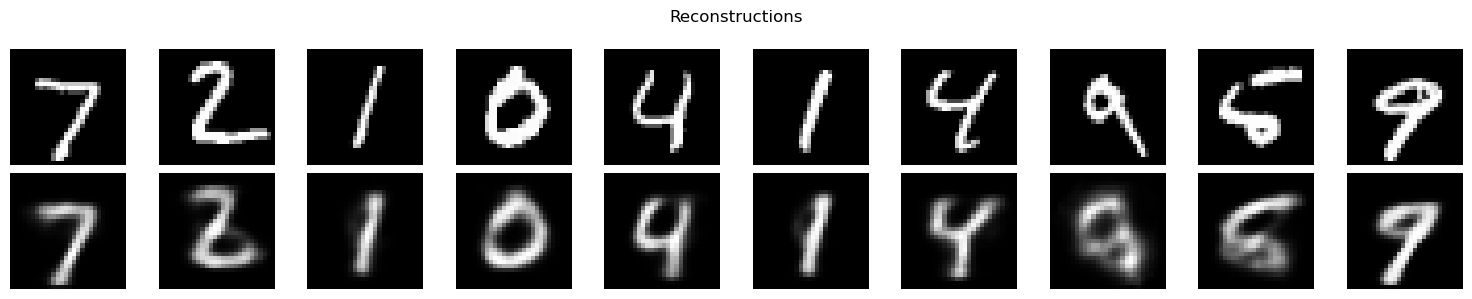

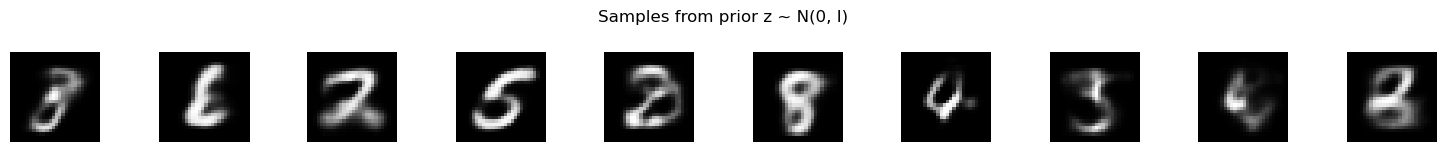

In [5]:
model.eval()
with torch.no_grad():
    # Reconstructions
    test_batch, _ = next(iter(test_loader))
    test_batch = test_batch.view(-1, 784).to(device)
    recon, _, _ = model(test_batch)
    
    fig, axes = plt.subplots(2, 10, figsize=(15, 3))
    for i in range(10):
        axes[0, i].imshow(test_batch[i].cpu().view(28, 28), cmap='gray')
        axes[1, i].imshow(recon[i].cpu().view(28, 28), cmap='gray')
        axes[0, i].axis('off'); axes[1, i].axis('off')
    axes[0, 0].set_ylabel('Original', fontsize=10)
    axes[1, 0].set_ylabel('Recon', fontsize=10)
    plt.suptitle('Reconstructions')
    plt.tight_layout(); plt.show()
    
    # Samples from prior
    z = torch.randn(10, 10).to(device)
    samples = model.decode(z)
    fig, axes = plt.subplots(1, 10, figsize=(15, 1.5))
    for i in range(10):
        axes[i].imshow(samples[i].cpu().view(28, 28), cmap='gray')
        axes[i].axis('off')
    plt.suptitle('Samples from prior z ~ N(0, I)')
    plt.tight_layout(); plt.show()

## Weight-Based Analysis: Algorithm 1 from BI_VAE.pdf

Given a target latent coordinate $\mu^*$, we derive which input patterns activate it by:
1. Mapping $\mu^*$ back to hidden space via $u = P_\mu^\top \mu^*$
2. Building the bilinear tensor and computing the interaction matrix
3. Projecting to input space and eigendecomposing

In [6]:
@torch.no_grad()
def analyze_latent_coordinate(model, mu_star):
    """Algorithm 1: Analyze which input patterns activate latent coordinate mu_star.
    
    Args:
        model: BilinearVAE
        mu_star: (d_latent,) target coordinate in latent space
    Returns:
        eigenvalues: sorted by |magnitude| descending
        eigenvectors: (n_components, 28, 28) input-space patterns
    """
    mu_star = mu_star.to(device)
    
    # Extract weights
    E = model.embed.weight                # (d_embed, d_input)
    W = model.bilinear.w_l                # (d_hidden, d_embed)
    V = model.bilinear.w_r                # (d_hidden, d_embed)
    P_mu = model.fc_mu.weight             # (d_latent, d_hidden)
    
    # Step 1: Map coordinate to hidden space
    u = P_mu.T @ mu_star                  # (d_hidden,)
    
    # Step 2-3: Interaction matrix in embedding space
    # Q_embed = sum_a u_a * W_a: * V_a:^T
    Q_embed = einsum(u, W, V, 'hidden, hidden emb1, hidden emb2 -> emb1 emb2')
    
    # Step 4: Symmetrize
    Q_sym = 0.5 * (Q_embed + Q_embed.T)
    
    # Step 5: Project to input space
    Q_input = E.T @ Q_sym @ E             # (d_input, d_input)
    
    # Step 6: Eigendecompose
    eigenvalues, eigenvectors = torch.linalg.eigh(Q_input)
    
    # Step 7: Sort by magnitude descending
    order = eigenvalues.abs().argsort(descending=True)
    eigenvalues = eigenvalues[order]
    eigenvectors = eigenvectors[:, order].T  # (n_components, d_input)
    
    return eigenvalues.cpu(), eigenvectors.cpu().view(-1, 28, 28)

## Plotting Helpers

In [7]:
def plot_eigenspectrum(eigenvalues, eigenvectors, title='', n_eig=4, n_spectrum=30):
    """Plot eigenvalue spectrum and top eigenvectors (positive & negative)."""
    fig, axes = plt.subplots(2, n_eig + 1, figsize=(3 * (n_eig + 1), 6))
    
    # Separate positive and negative eigenvalues
    pos_mask = eigenvalues > 0
    neg_mask = eigenvalues < 0
    
    # Top positive eigenvalues/vectors
    pos_idx = torch.where(pos_mask)[0][:n_spectrum]
    pos_vals = eigenvalues[pos_idx] if len(pos_idx) > 0 else torch.zeros(1)
    axes[0, 0].barh(range(len(pos_vals)), pos_vals.numpy(), color='steelblue')
    axes[0, 0].set_title('+ eigenvalues')
    axes[0, 0].invert_yaxis()
    
    # Top negative eigenvalues/vectors
    neg_idx = torch.where(neg_mask)[0][:n_spectrum]
    neg_vals = eigenvalues[neg_idx] if len(neg_idx) > 0 else torch.zeros(1)
    axes[1, 0].barh(range(len(neg_vals)), neg_vals.numpy(), color='indianred')
    axes[1, 0].set_title('- eigenvalues')
    axes[1, 0].invert_yaxis()
    
    # Plot top eigenvectors
    vmax = eigenvectors[:n_eig*2].abs().max().item()
    for i in range(n_eig):
        # Positive eigenvectors
        if i < len(pos_idx):
            axes[0, i+1].imshow(eigenvectors[pos_idx[i]].numpy(), cmap='RdBu_r', vmin=-vmax, vmax=vmax)
        axes[0, i+1].axis('off')
        
        # Negative eigenvectors
        if i < len(neg_idx):
            axes[1, i+1].imshow(eigenvectors[neg_idx[i]].numpy(), cmap='RdBu_r', vmin=-vmax, vmax=vmax)
        axes[1, i+1].axis('off')
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout(); plt.show()

## Analysis 1: Standard Basis Vectors (Individual Latent Dimensions)

Setting $\mu^* = e_k$ (one-hot) reveals what input patterns each latent dimension responds to.

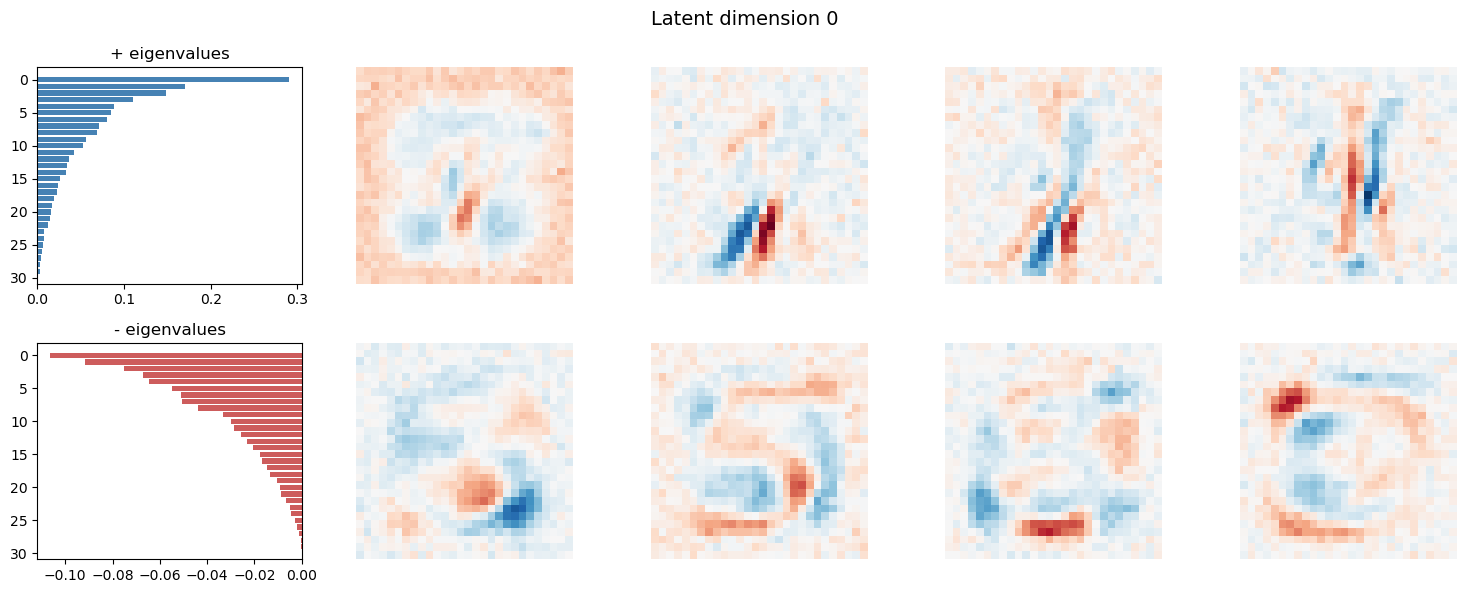

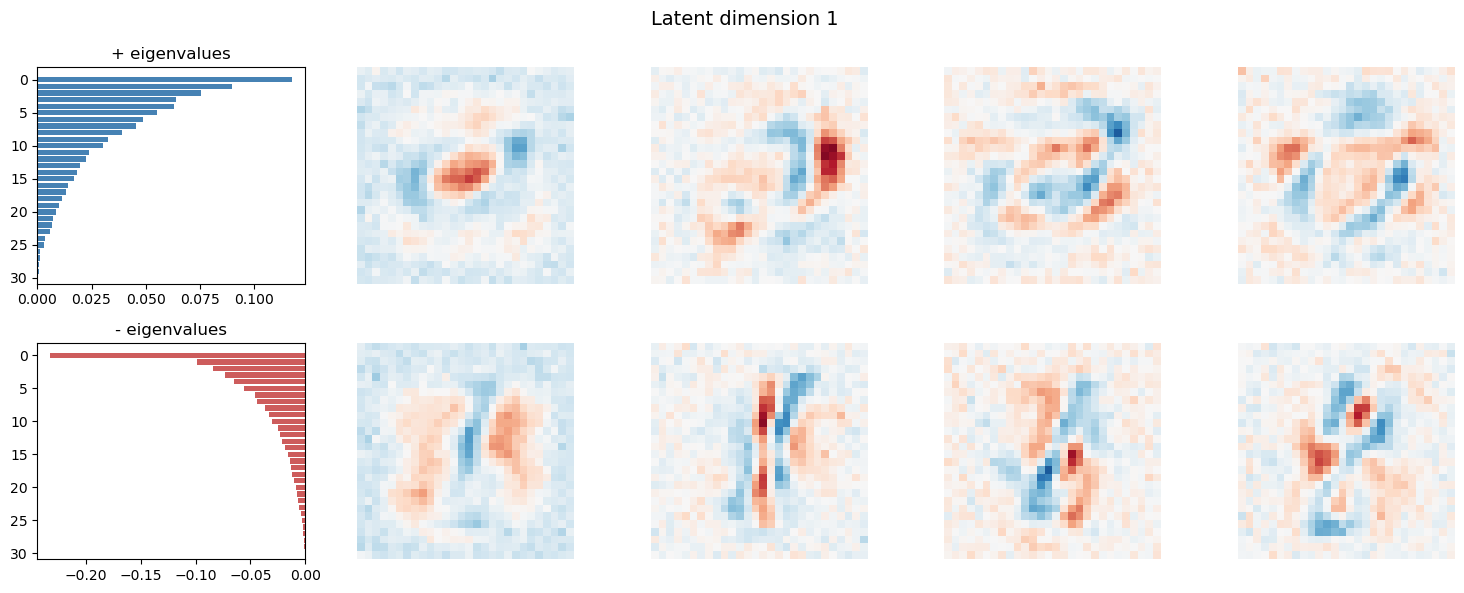

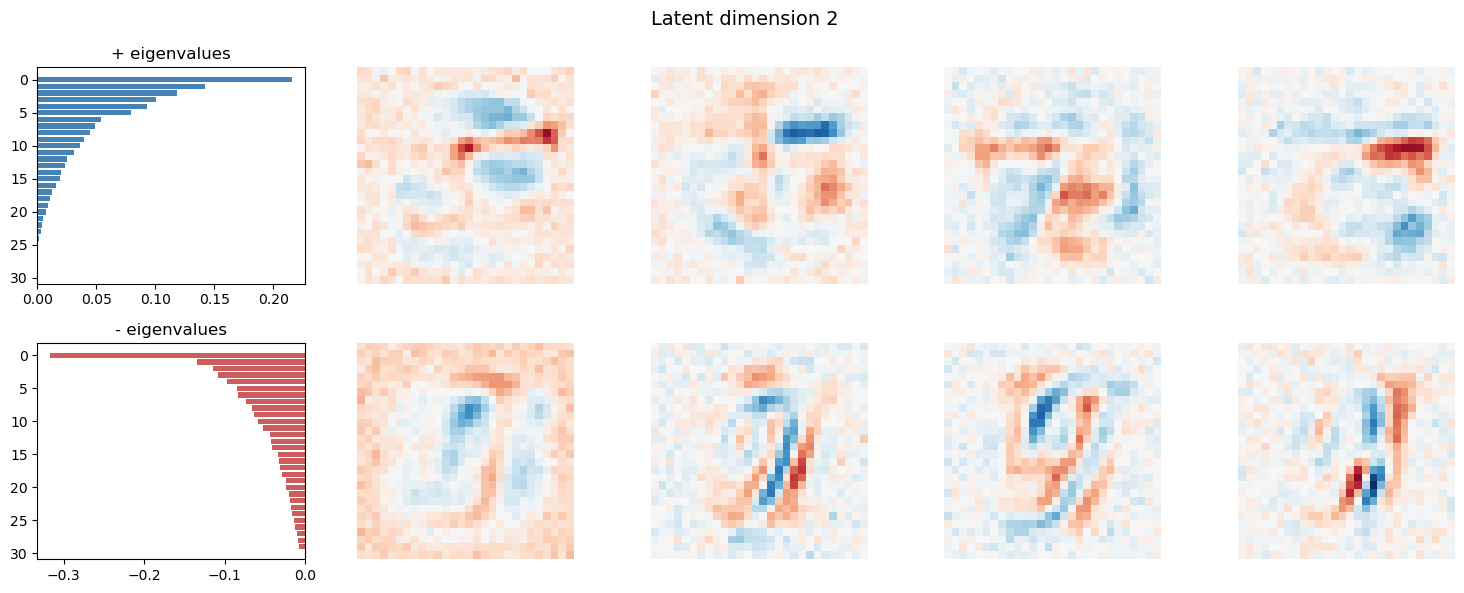

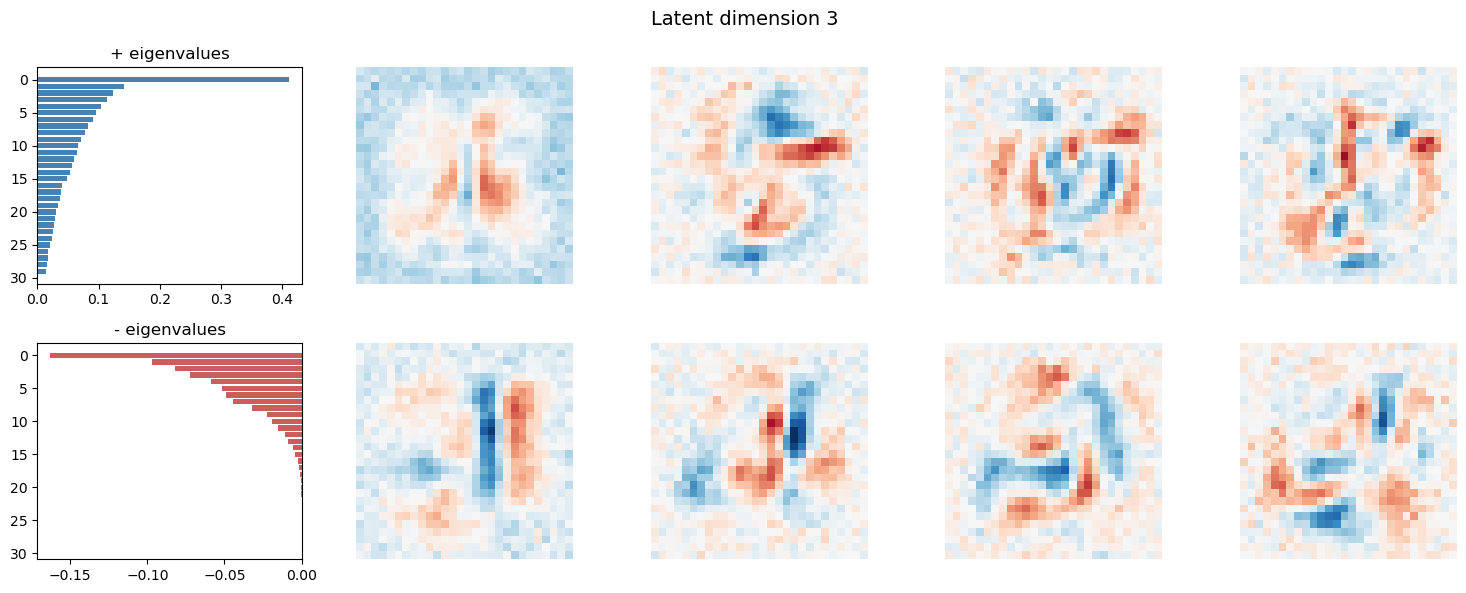

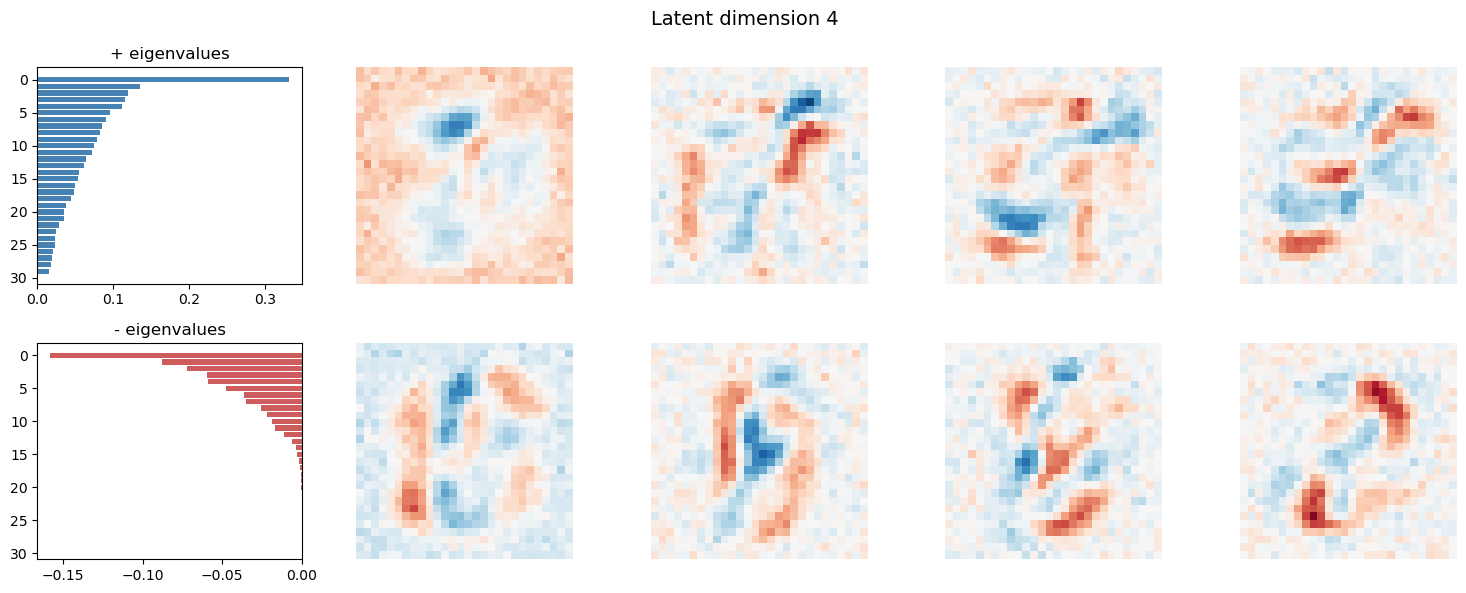

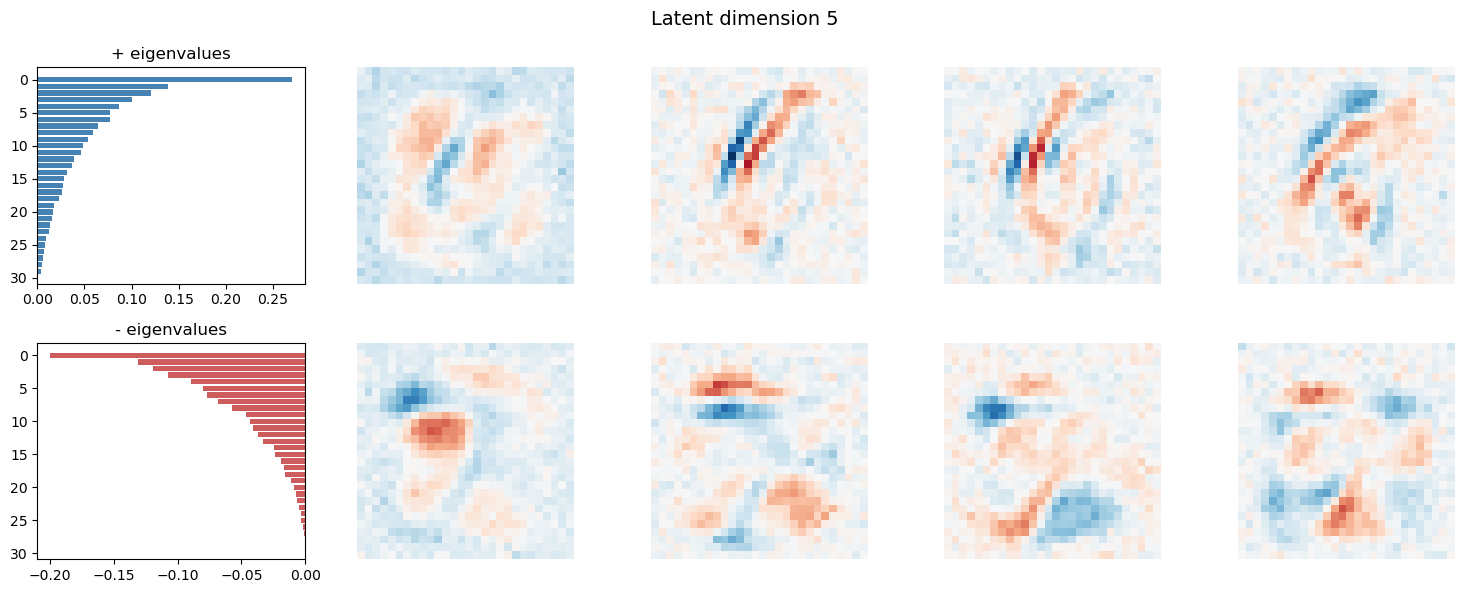

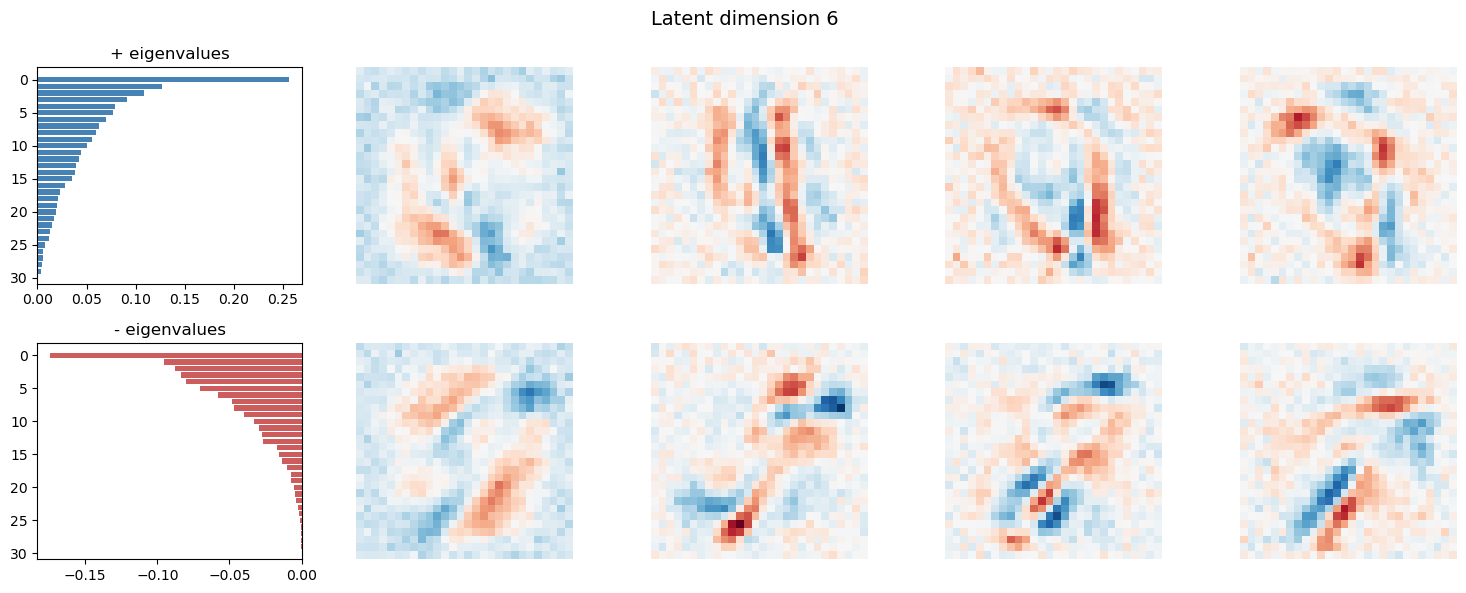

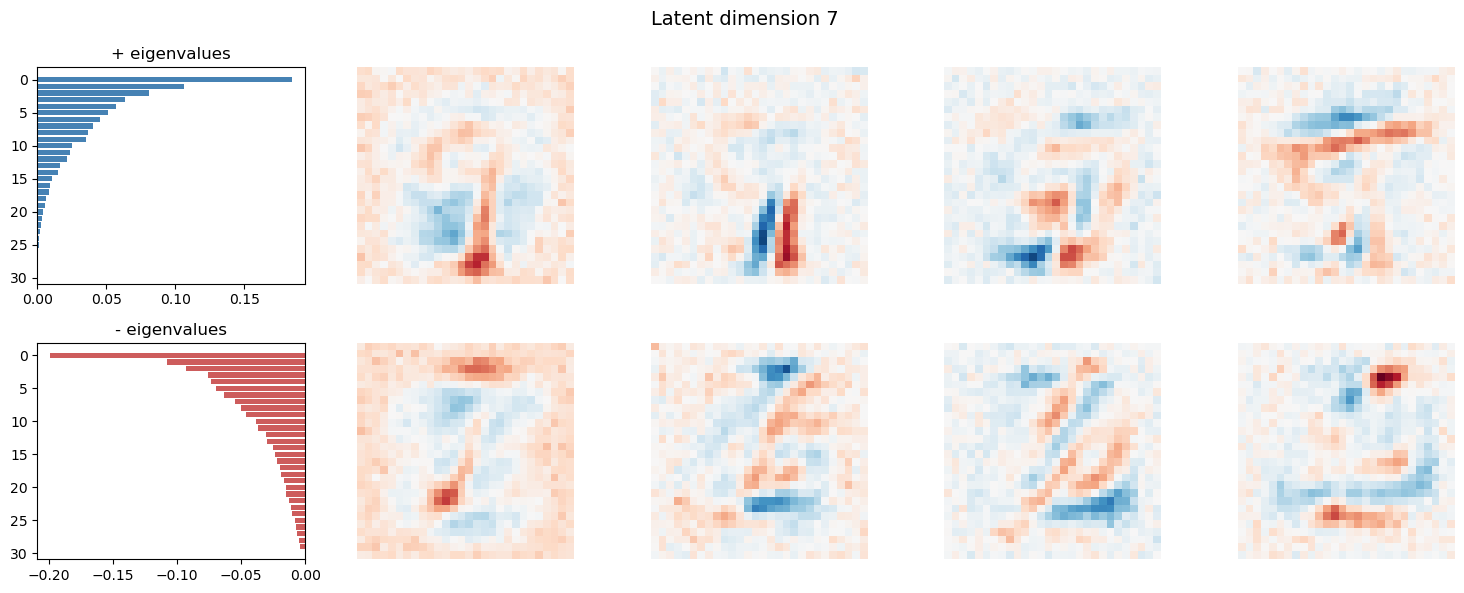

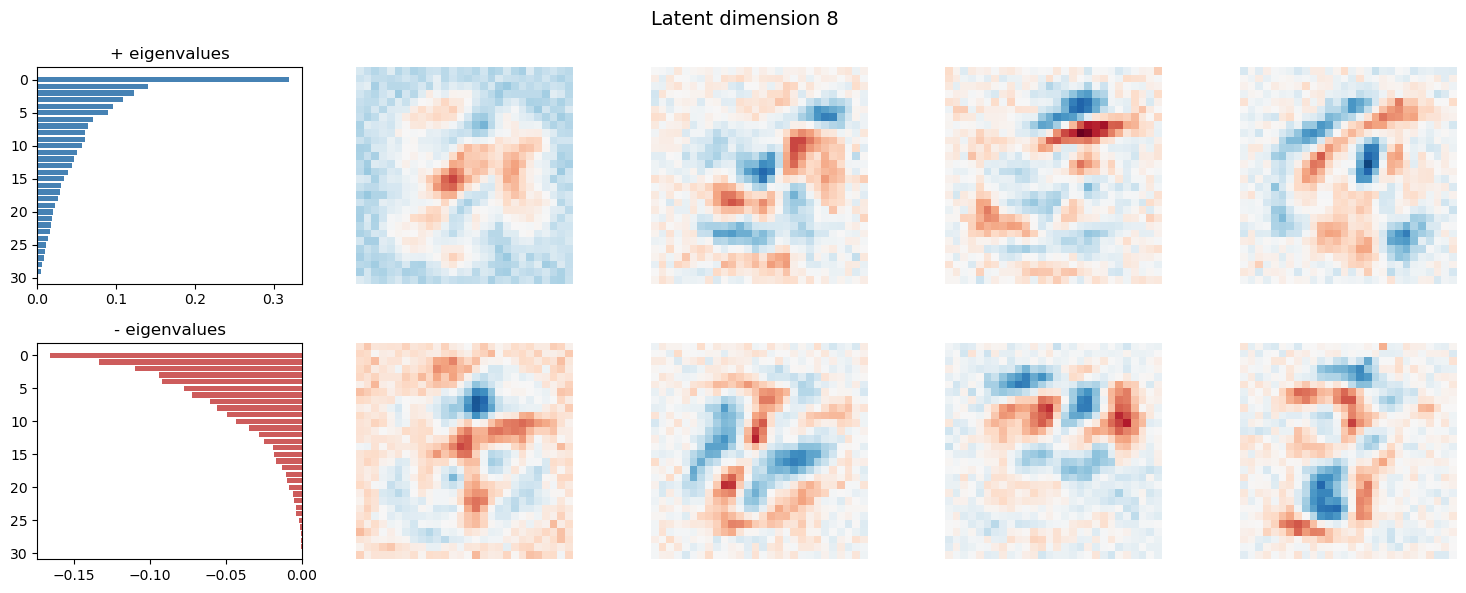

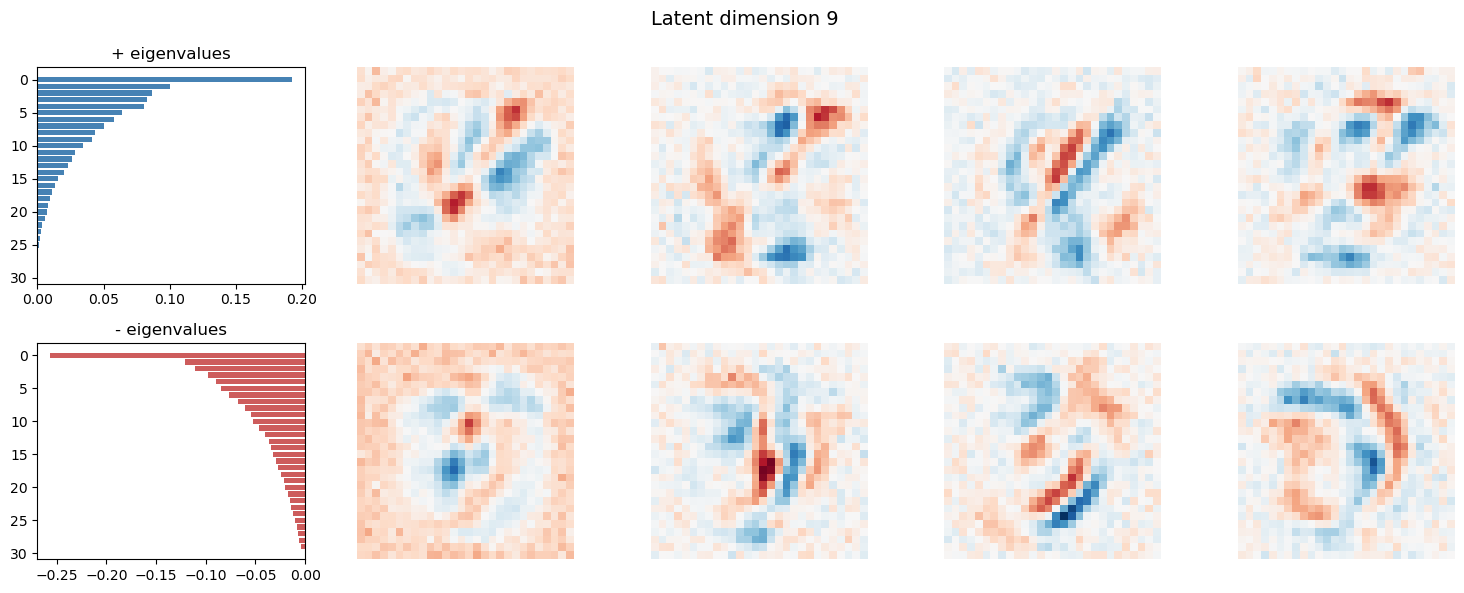

In [8]:
for k in range(model.d_latent):
    mu_star = torch.zeros(model.d_latent)
    mu_star[k] = 1.0
    vals, vecs = analyze_latent_coordinate(model, mu_star)
    plot_eigenspectrum(vals, vecs, title=f'Latent dimension {k}')

## Analysis 2: Mean Class Encodings

Setting $\mu^* = \mathbb{E}[\mu(x) | y = c]$ reveals what pixel features characterize each digit class.

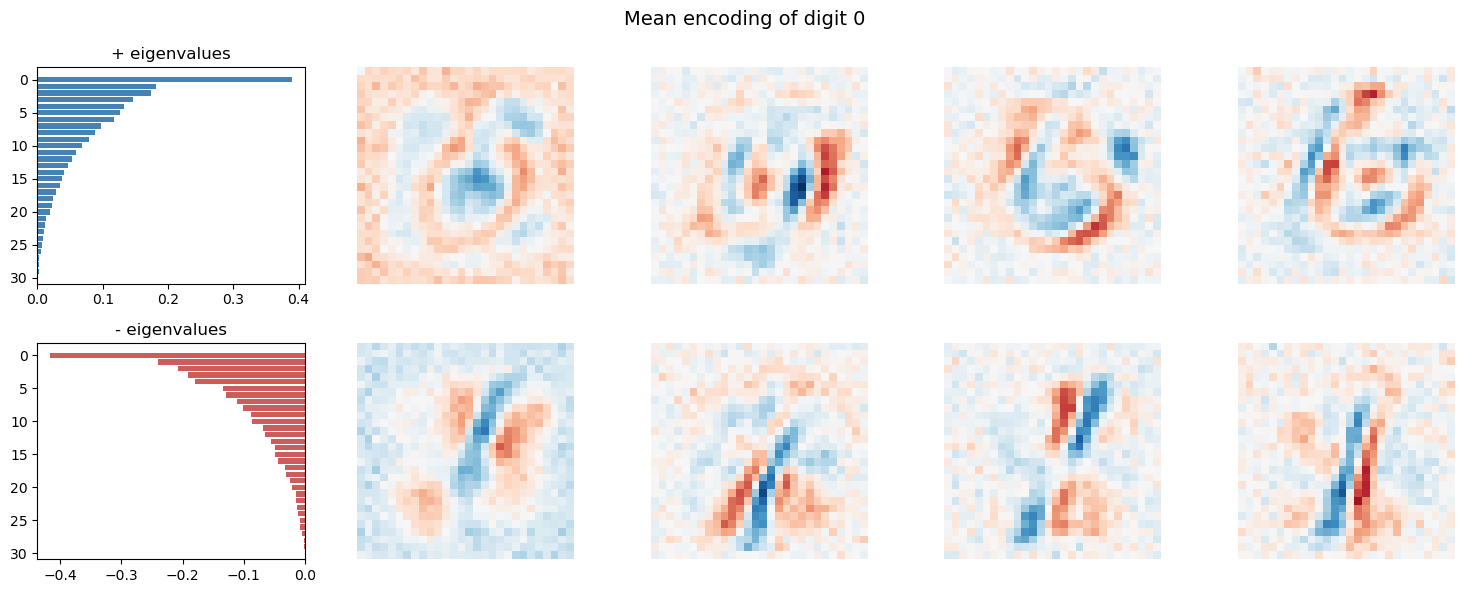

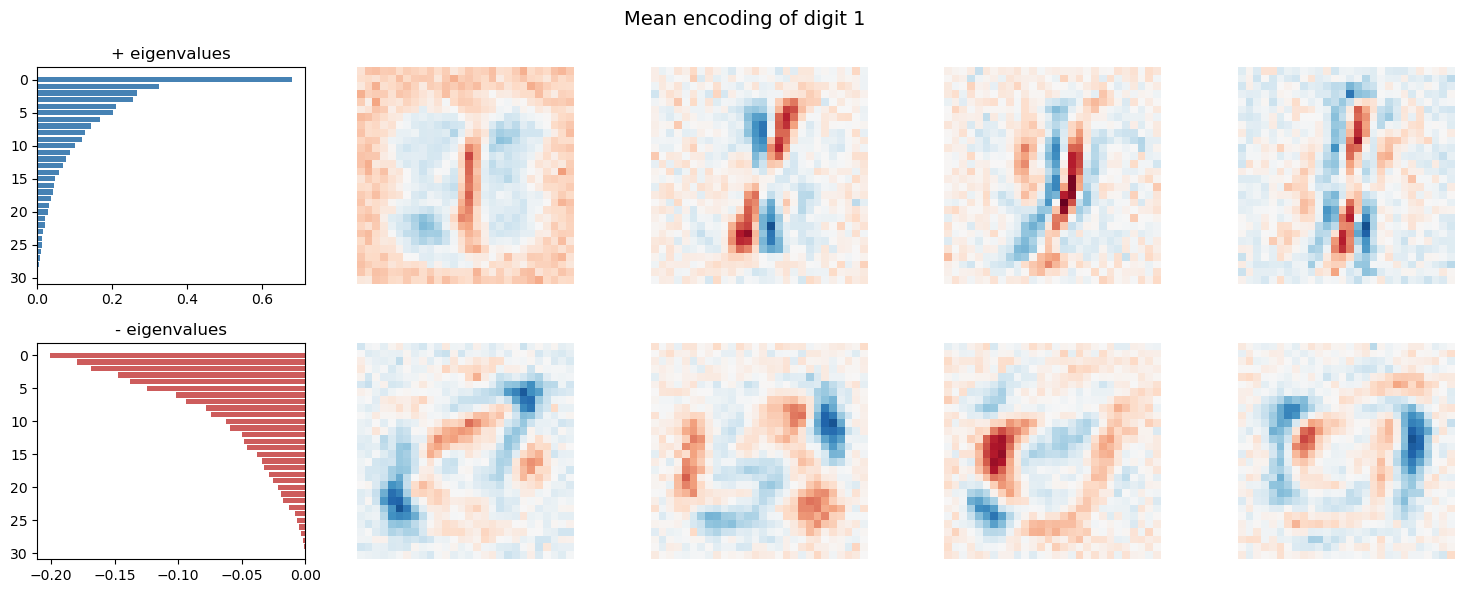

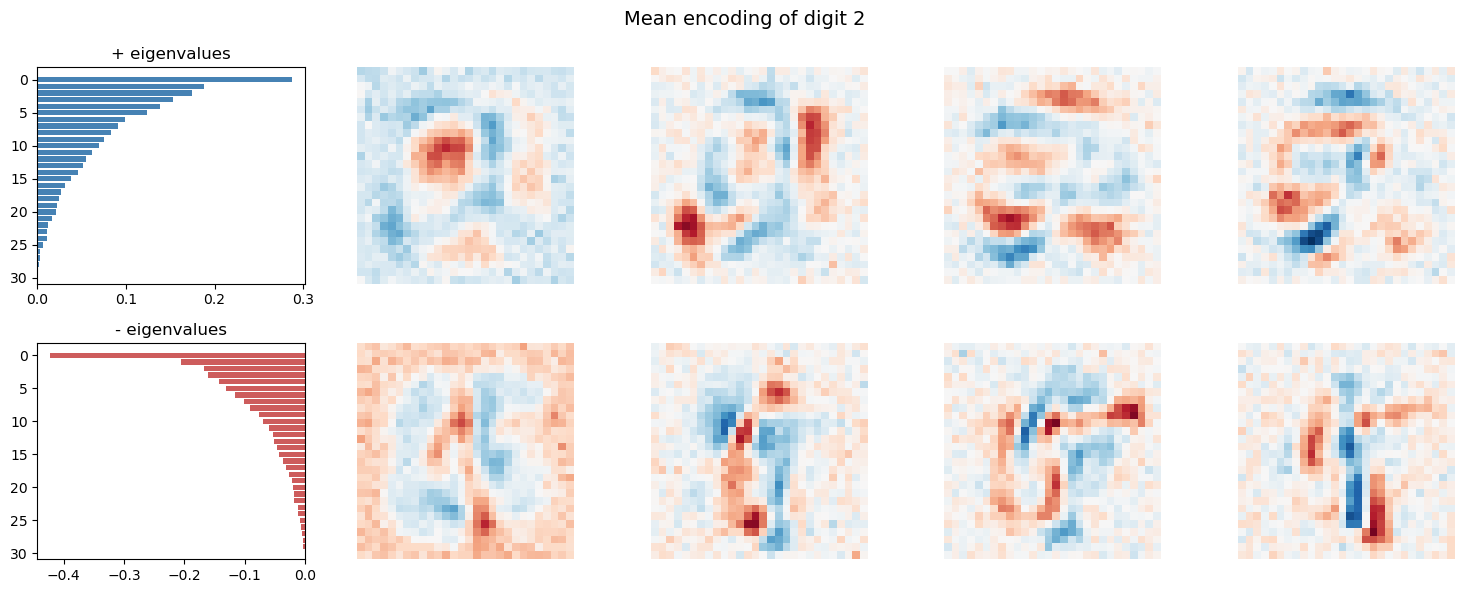

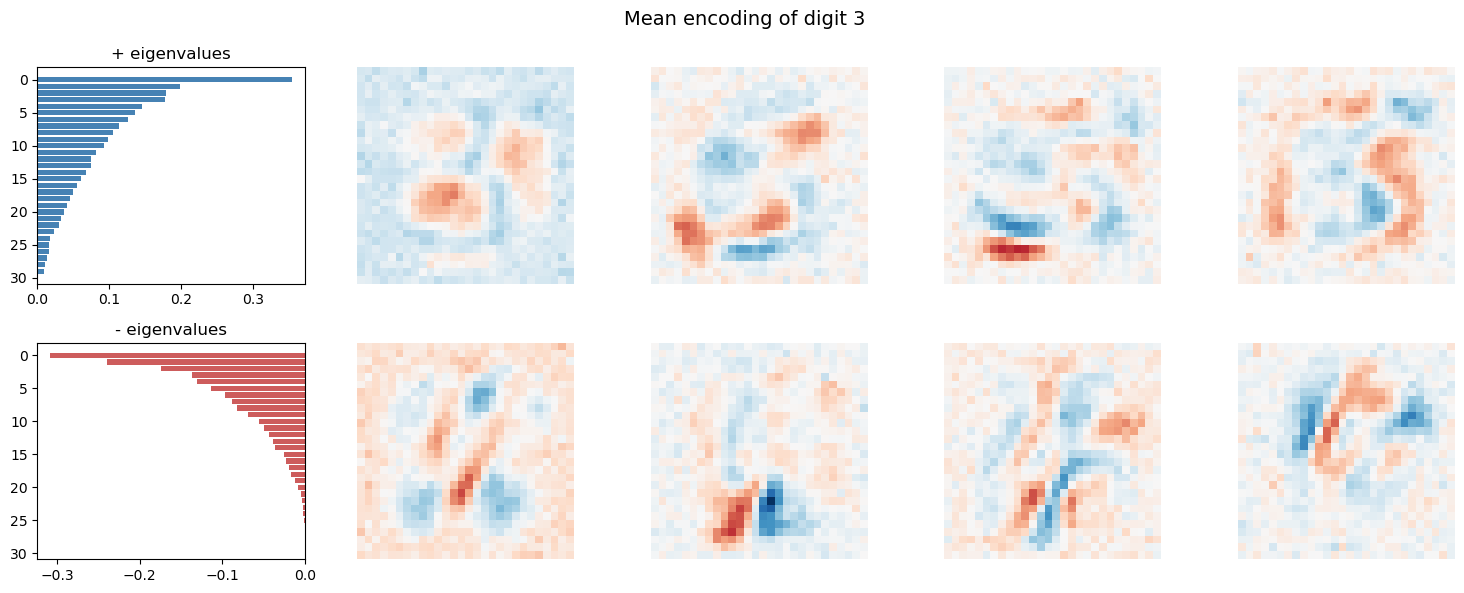

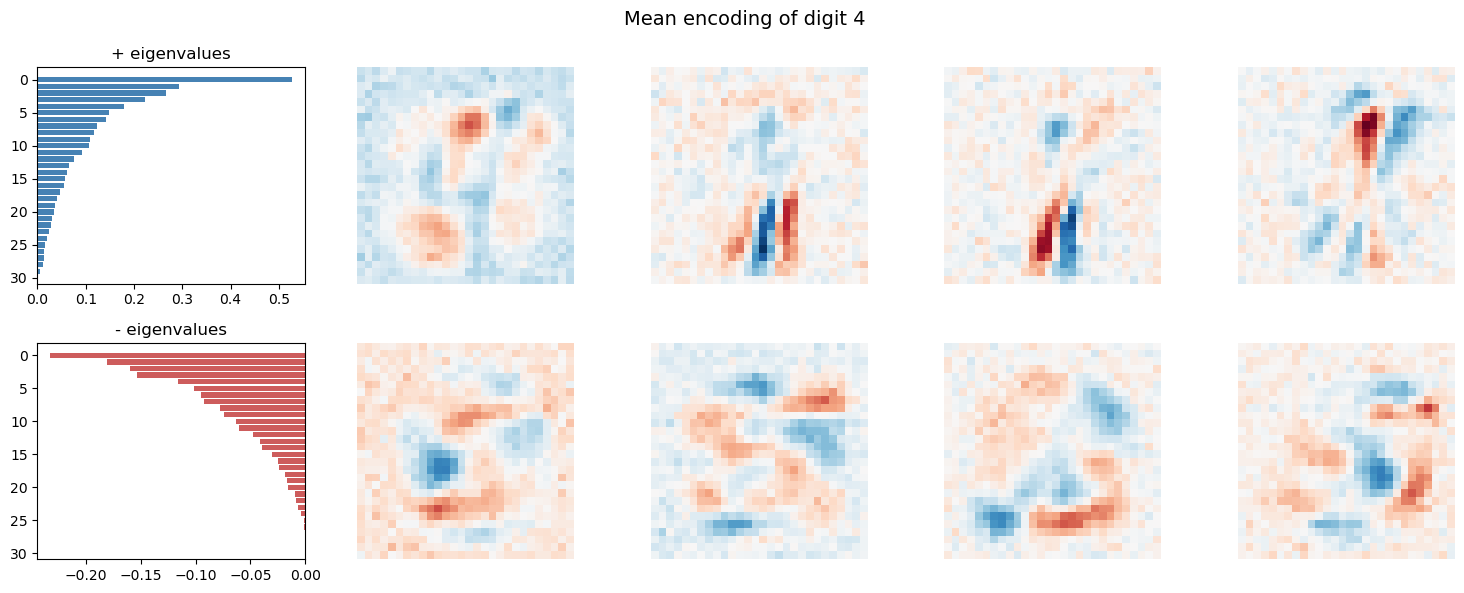

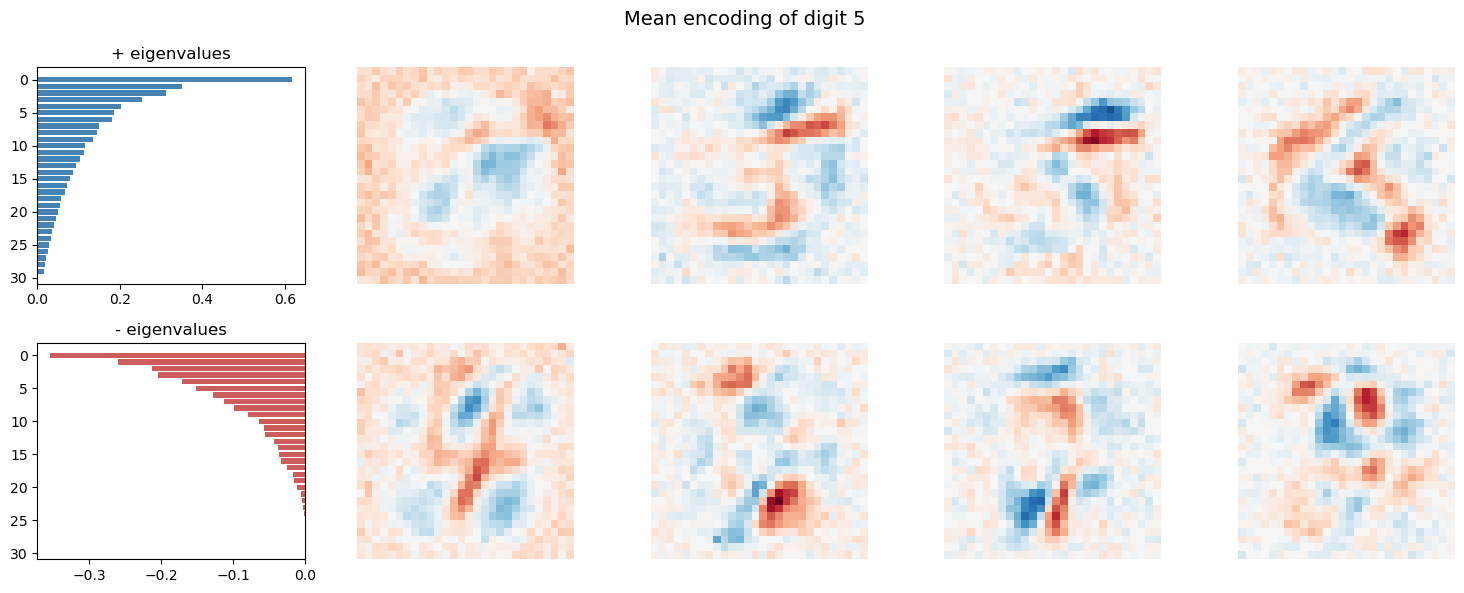

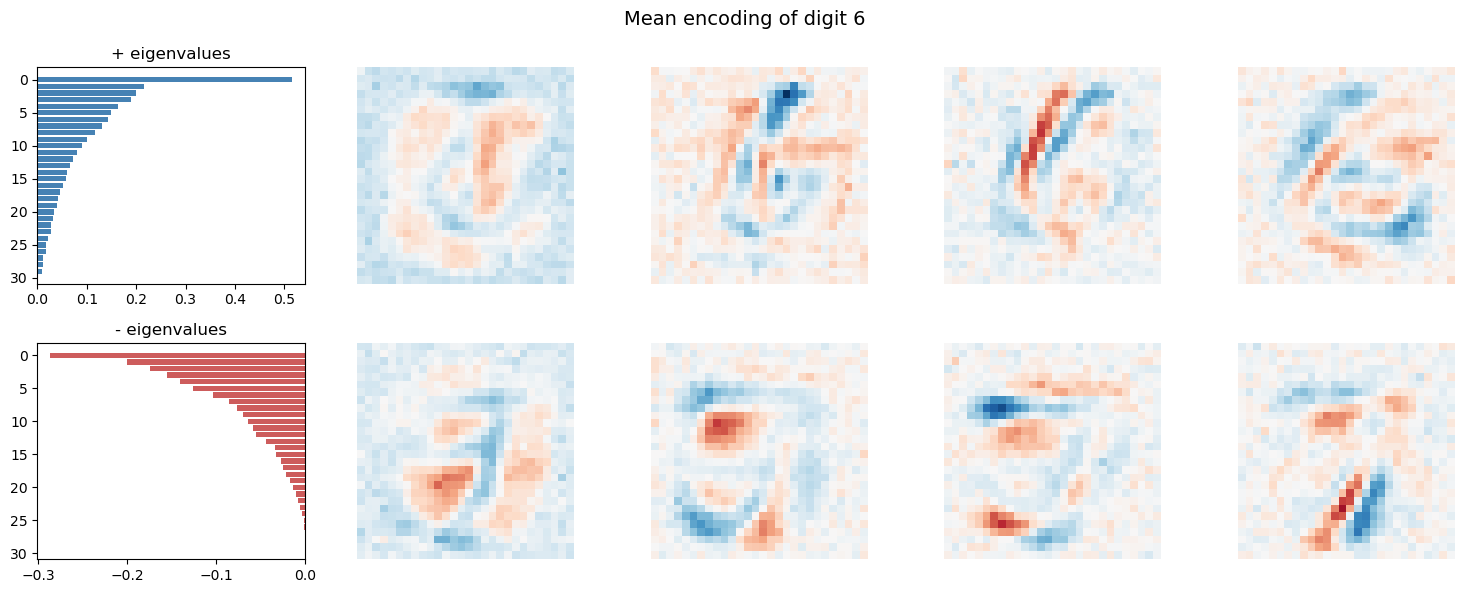

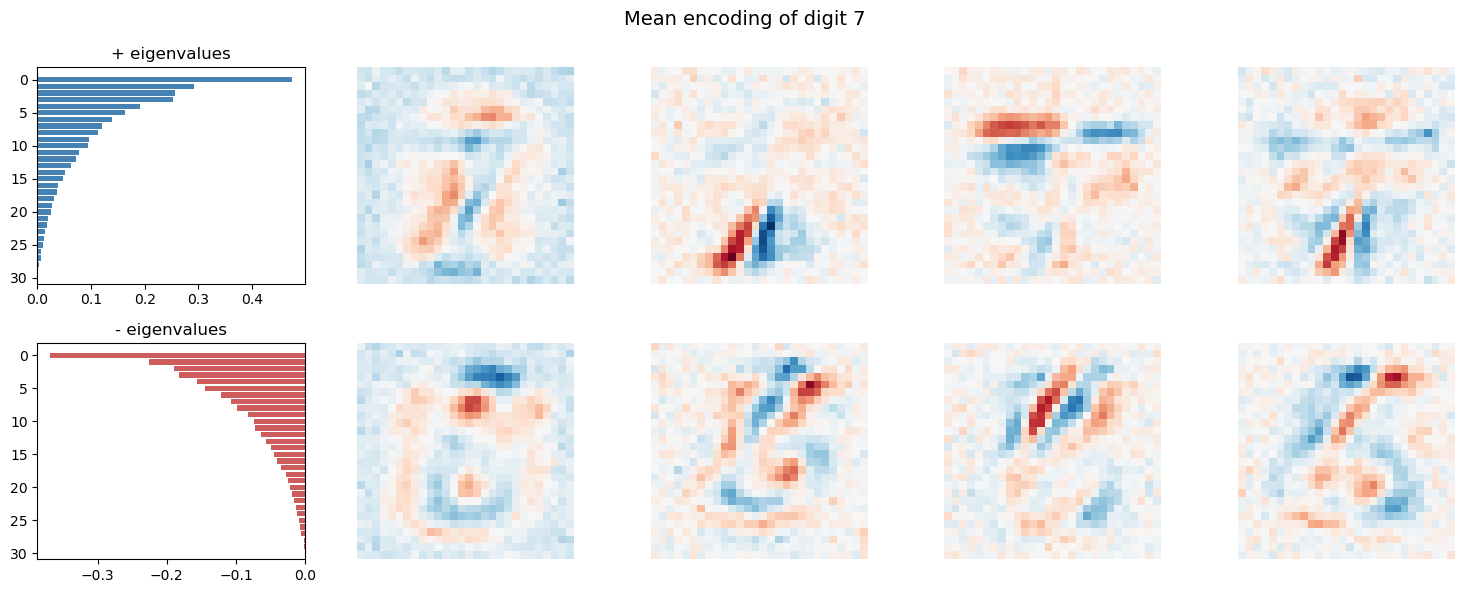

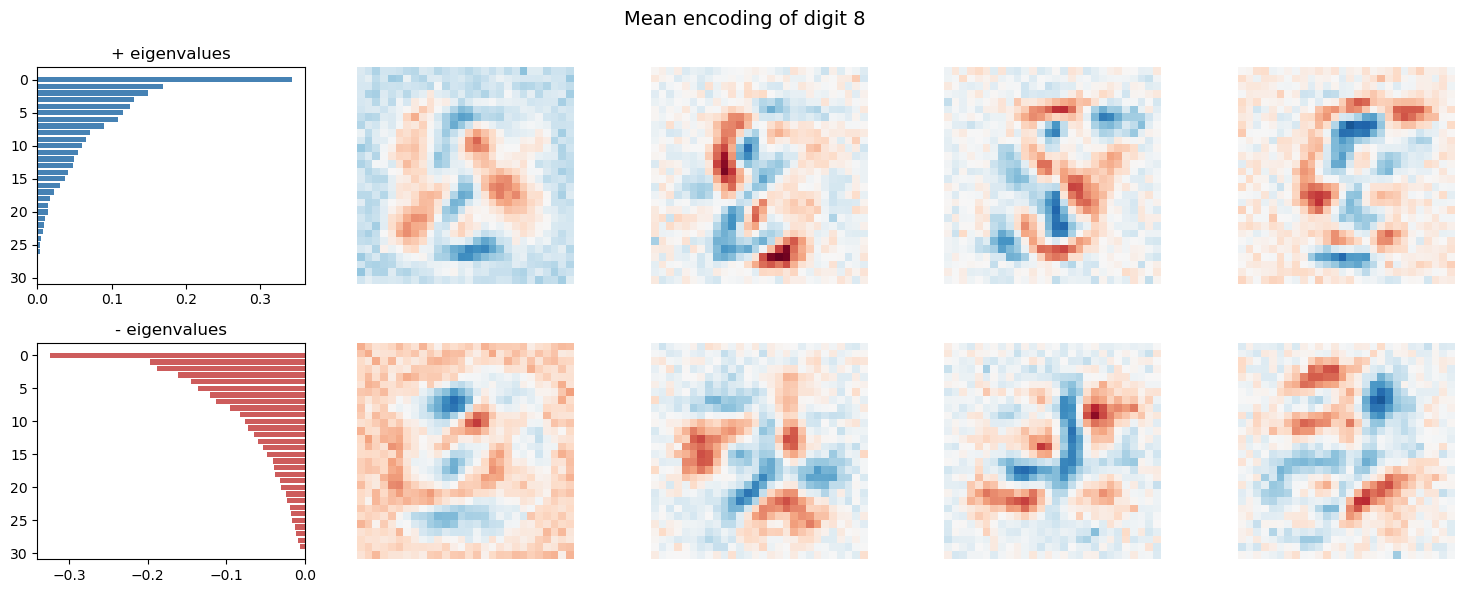

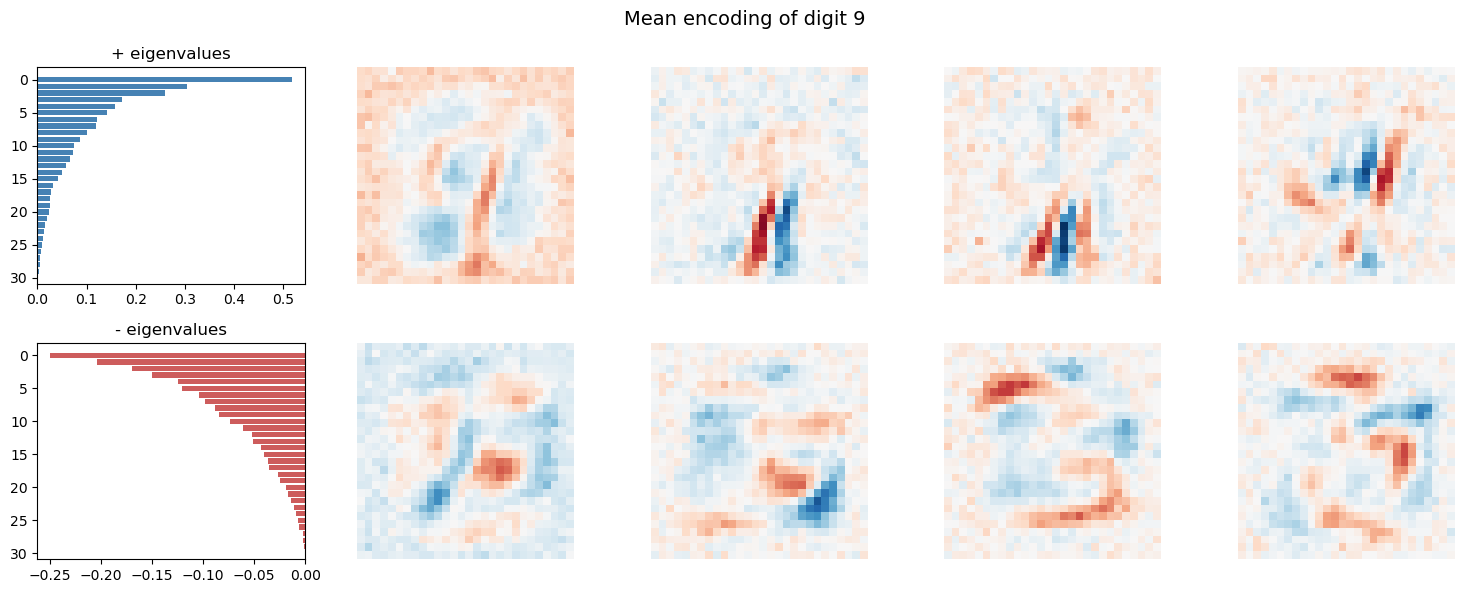

In [9]:
# Compute per-class mean encodings
model.eval()
class_mus = {c: [] for c in range(10)}

with torch.no_grad():
    for batch, labels in test_loader:
        batch = batch.view(-1, 784).to(device)
        mu, _ = model.encode(batch)
        for i, label in enumerate(labels):
            class_mus[label.item()].append(mu[i].cpu())

mean_mus = {c: torch.stack(vs).mean(0) for c, vs in class_mus.items()}

for digit in range(10):
    vals, vecs = analyze_latent_coordinate(model, mean_mus[digit])
    plot_eigenspectrum(vals, vecs, title=f'Mean encoding of digit {digit}')

## Analysis 3: Eigenvalue Spectrum Comparison

Compare eigenvalue distributions across latent dimensions and class means to see low-rank structure.

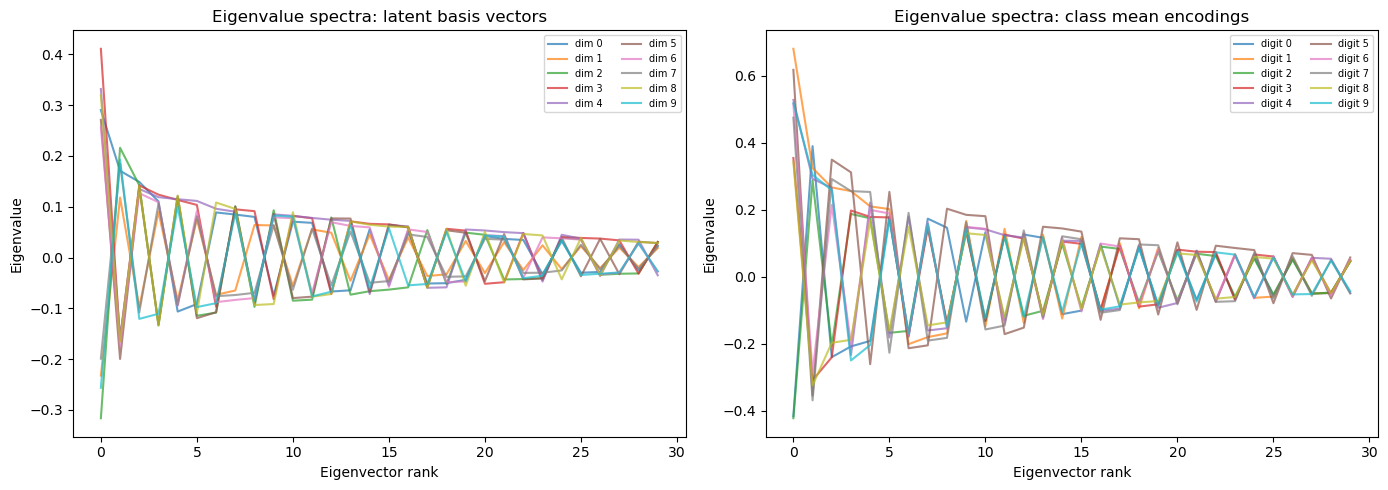

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Latent dimensions
for k in range(model.d_latent):
    mu_star = torch.zeros(model.d_latent)
    mu_star[k] = 1.0
    vals, _ = analyze_latent_coordinate(model, mu_star)
    axes[0].plot(vals[:30].numpy(), label=f'dim {k}', alpha=0.7)
axes[0].set_title('Eigenvalue spectra: latent basis vectors')
axes[0].set_xlabel('Eigenvector rank')
axes[0].set_ylabel('Eigenvalue')
axes[0].legend(fontsize=7, ncol=2)

# Class means
for digit in range(10):
    vals, _ = analyze_latent_coordinate(model, mean_mus[digit])
    axes[1].plot(vals[:30].numpy(), label=f'digit {digit}', alpha=0.7)
axes[1].set_title('Eigenvalue spectra: class mean encodings')
axes[1].set_xlabel('Eigenvector rank')
axes[1].set_ylabel('Eigenvalue')
axes[1].legend(fontsize=7, ncol=2)

plt.tight_layout(); plt.show()

## Analysis 4: Interpolation Between Digits

Blend between class mean encodings (e.g. digit 5 → digit 3) and see how the encoder's input patterns transition. This uses $\mu^* = \alpha \mu_A + (1 - \alpha) \mu_B$ — still pure weight analysis, no decoder.

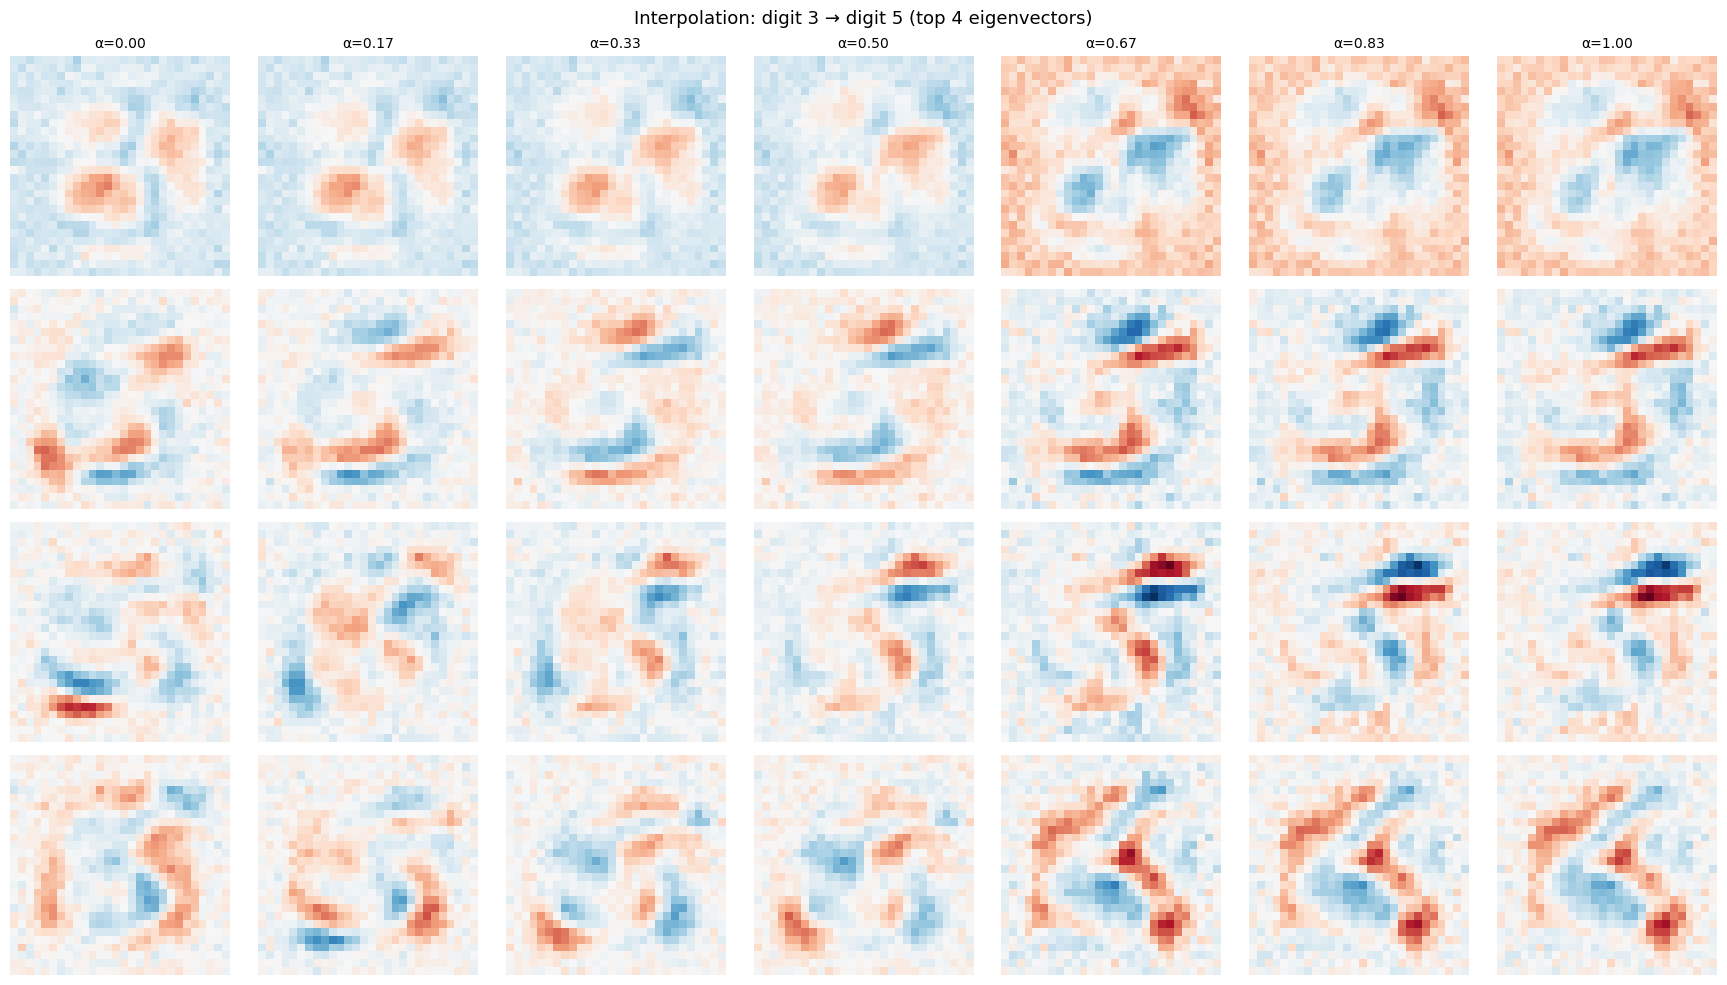

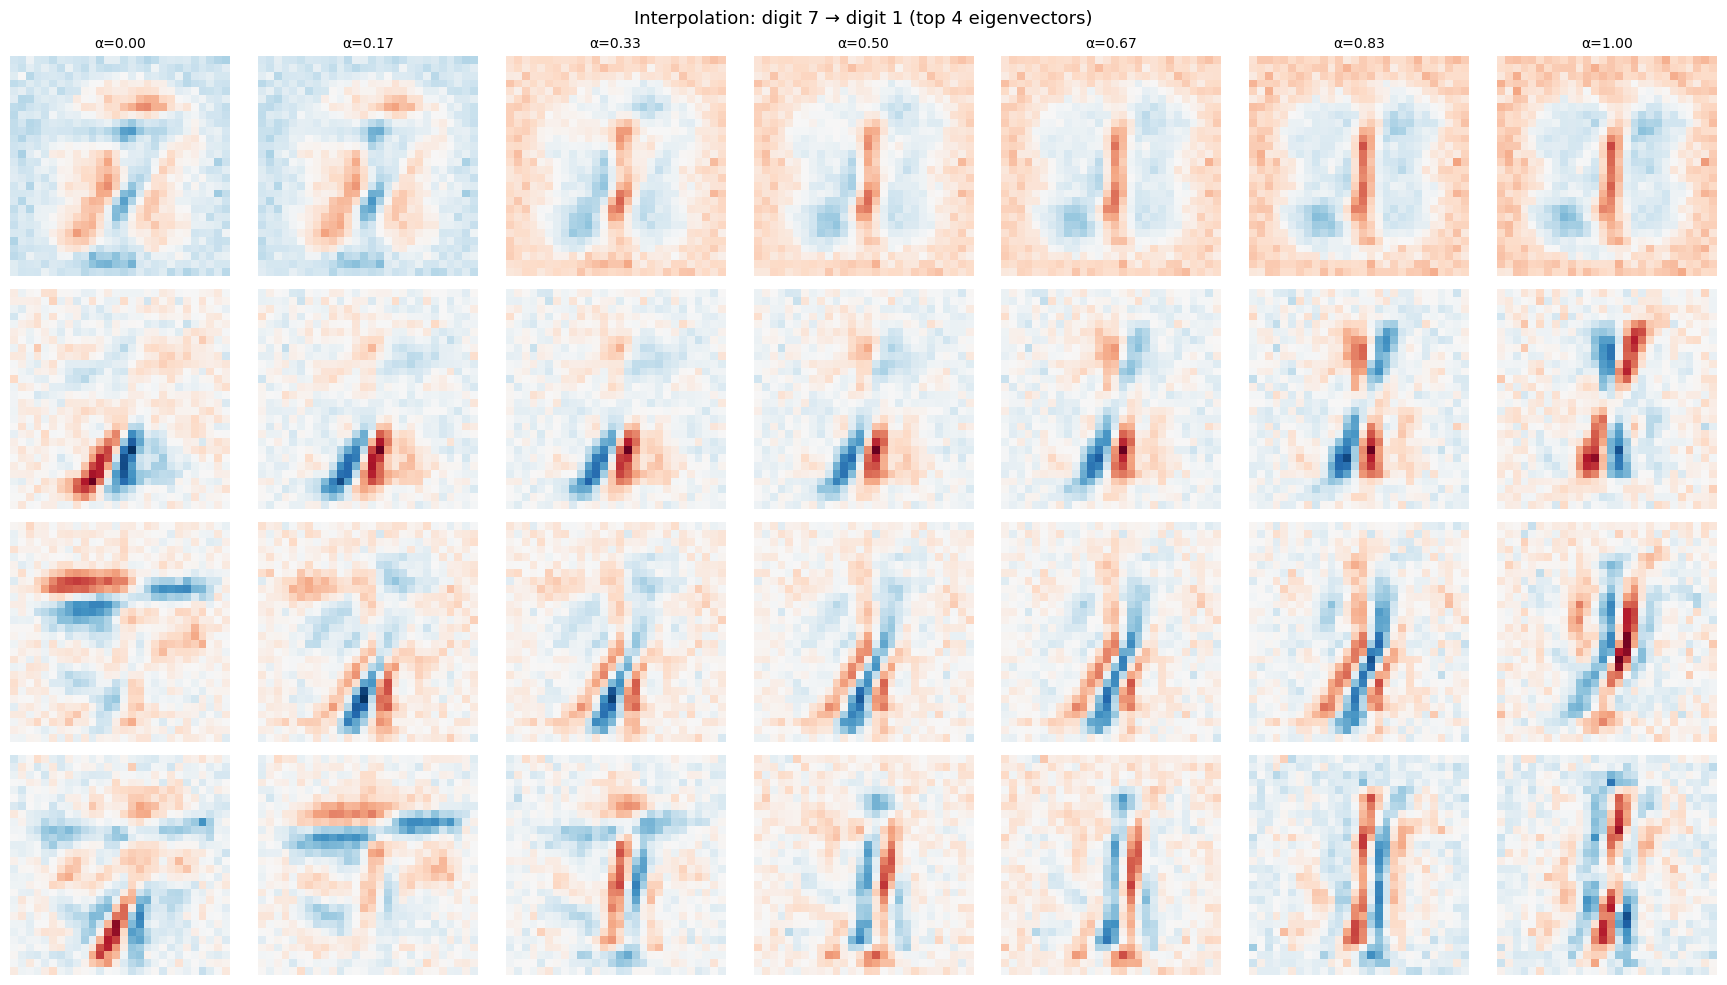

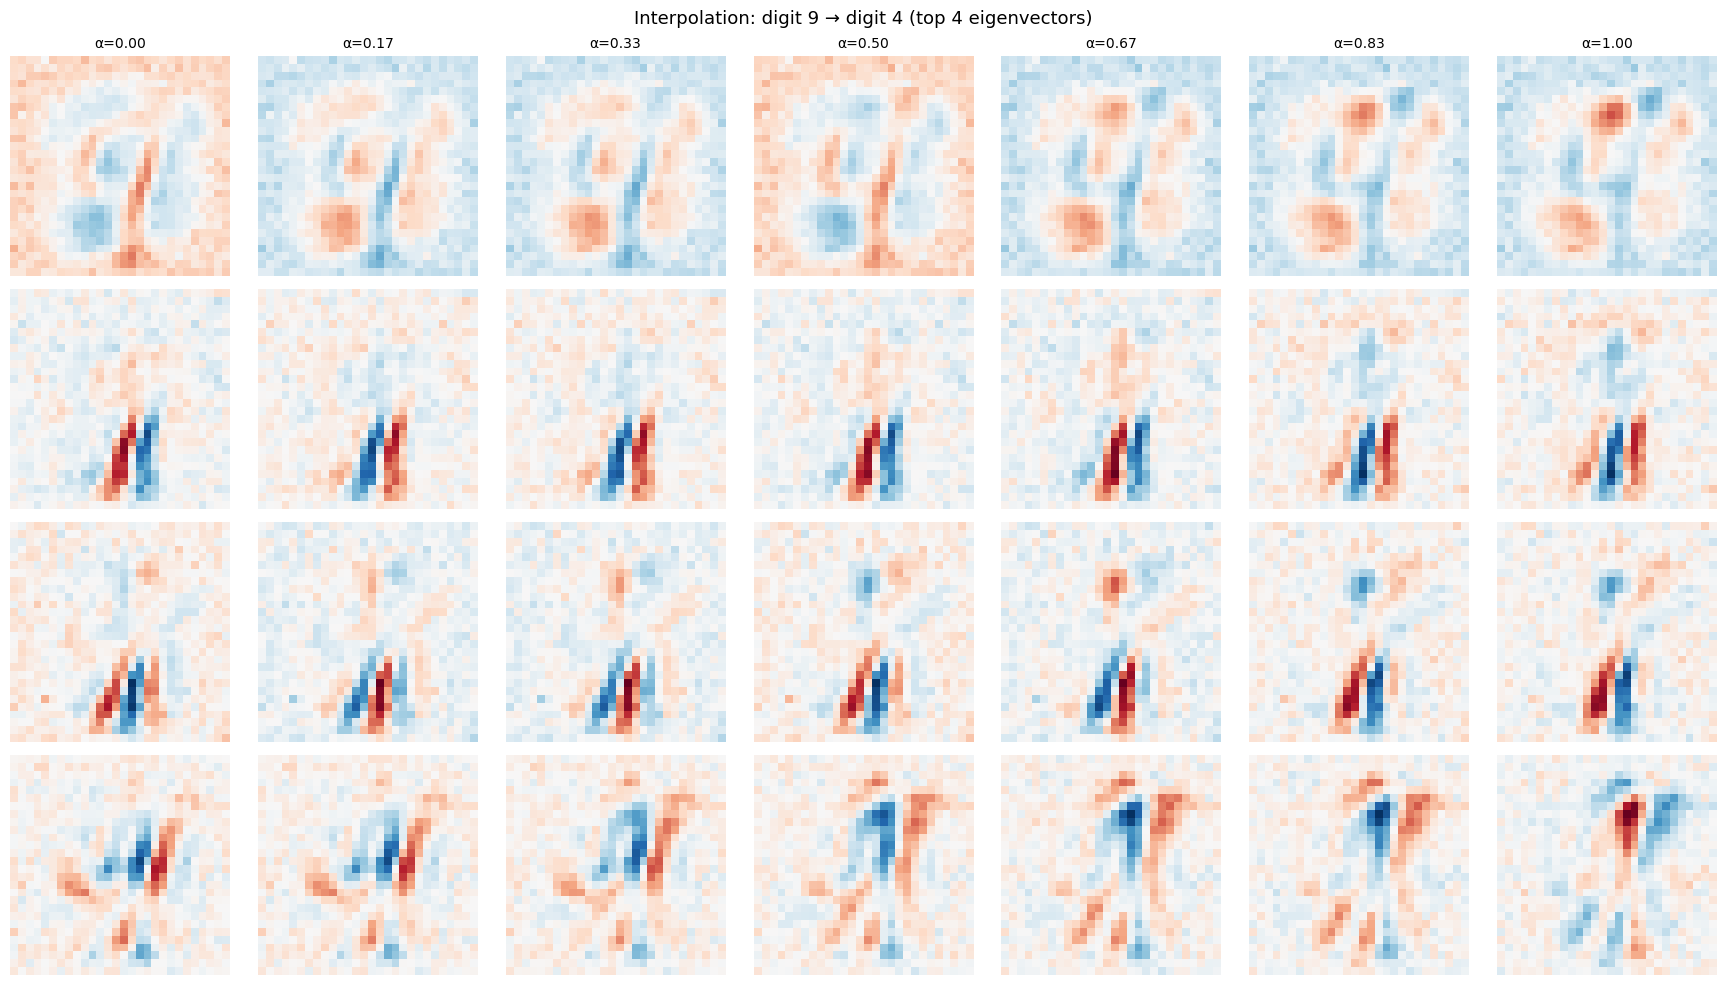

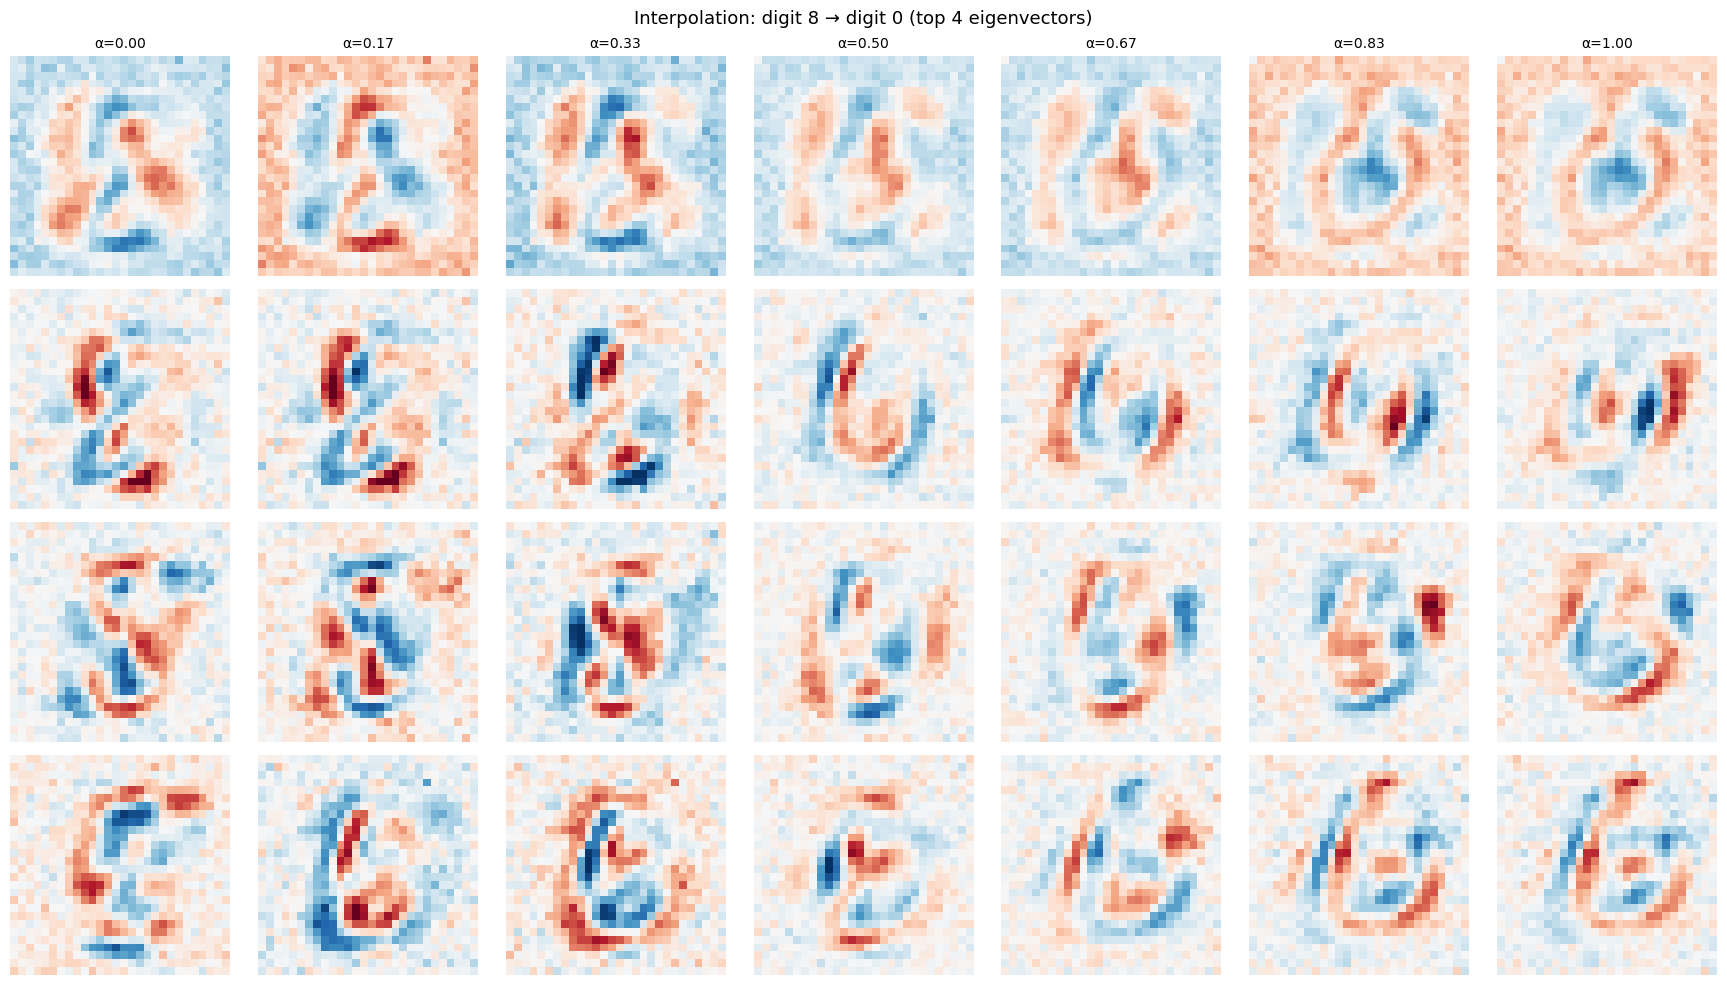

In [11]:
def plot_interpolation(model, mean_mus, digit_a, digit_b, n_steps=7, n_eig=4):
    """Interpolate between two class means and show top eigenvectors at each step."""
    alphas = np.linspace(0, 1, n_steps)
    
    fig, axes = plt.subplots(n_eig, n_steps, figsize=(2.5 * n_steps, 2.5 * n_eig))
    
    for j, alpha in enumerate(alphas):
        mu_star = alpha * mean_mus[digit_a] + (1 - alpha) * mean_mus[digit_b]
        vals, vecs = analyze_latent_coordinate(model, mu_star)
        
        # Show top positive eigenvectors
        pos_idx = torch.where(vals > 0)[0]
        vmax = vecs[:n_eig].abs().max().item()
        for i in range(n_eig):
            if i < len(pos_idx):
                axes[i, j].imshow(vecs[pos_idx[i]].numpy(), cmap='RdBu_r', vmin=-vmax, vmax=vmax)
            axes[i, j].axis('off')
            if i == 0:
                axes[i, j].set_title(f'α={alpha:.2f}', fontsize=10)
    
    axes[0, 0].set_ylabel(f'← digit {digit_b}', fontsize=10)
    axes[0, -1].set_ylabel(f'digit {digit_a} →', fontsize=10, rotation=-90, labelpad=15)
    plt.suptitle(f'Interpolation: digit {digit_b} → digit {digit_a} (top {n_eig} eigenvectors)', fontsize=13)
    plt.tight_layout(); plt.show()

# Digit 5 ↔ 3
plot_interpolation(model, mean_mus, digit_a=5, digit_b=3)

# Digit 1 ↔ 7
plot_interpolation(model, mean_mus, digit_a=1, digit_b=7)

# Digit 4 ↔ 9
plot_interpolation(model, mean_mus, digit_a=4, digit_b=9)

# Digit 0 ↔ 8
plot_interpolation(model, mean_mus, digit_a=0, digit_b=8)